# STA2453 Assn 1 - David Veitch

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as st
from scipy.special import comb
%matplotlib inline
pd.options.display.max_rows = 10

# Create Dataset From Scratch

In [143]:
# From British Medical Jounral Paper Volume 292 pg 880
# Group Info List
# [Treatment Name,Treament Type (Open/NephPerc),Group 1 No Success, Group 1 Success, Group 2 No Success, Group 2 Success]
group_info = [['Neprholithotomy/pyelolithotomy','Open',1,12,64,154],
             ['Pyeloithotomy','Open',5,26,7,38],
             ['Ureterolithotomy','Open',0,43,0,0],
             ['Percutaneous nephrolithotomy','Percutaneous nephrolithotomy',36,234,25,55]]

master_df = pd.DataFrame()

# iterate through group_info to create master df of problems
for group in group_info:
    for group_no in [1,2]:  
        for success in [0,1]:
            # Create one example of a member in group[0], with group type group[1], 
            # and group number group_no, with success equal to success (either 0 or 1)
            new_patient_df = pd.DataFrame({'Treatment Name':group[0],'Treatment Type':group[1],
                                           'Group (1 - <2cm, 2 - >= 2cm)':group_no,'Success (0 - No, 1 - Yes)':success},index=[0])
            # Create number of entries of dataframe according to dataset
            new_patient_df = pd.DataFrame(new_patient_df.values.repeat(group[group_no*2+success],axis=0), 
                                          columns=new_patient_df.columns)
            # Merge new group with master_df
            master_df = pd.concat([master_df,new_patient_df])
            
# reset_index makes patient number go from 0-699

master_df=master_df.reset_index(drop=True)
master_df.index.name = 'PatientNo'
master_df

,"Group (1 - <2cm, 2 - >= 2cm)","Success (0 - No, 1 - Yes)",Treatment Name,Treatment Type
PatientNo,,,,
0,1,0,Neprholithotomy/pyelolithotomy,Open
1,1,1,Neprholithotomy/pyelolithotomy,Open
2,1,1,Neprholithotomy/pyelolithotomy,Open
3,1,1,Neprholithotomy/pyelolithotomy,Open
4,1,1,Neprholithotomy/pyelolithotomy,Open
...,...,...,...,...
695,2,1,Percutaneous nephrolithotomy,Percutaneous nephrolithotomy
696,2,1,Percutaneous nephrolithotomy,Percutaneous nephrolithotomy
697,2,1,Percutaneous nephrolithotomy,Percutaneous nephrolithotomy


# Comparing Proportions Across Groups (Non-Exact Methods)

To compare the proportion of successes across two groups we will use a two tailed test. In each test we will compare the proportion of success from one of the open procedures with that of the Percutaneous Nephrolithotomy procedure of the same group. 

For example in one of the tests the null and alternative hypotheses are:

$$H_0 : p_{Pyelolithotomy,Group 1} = p_{Percutaneous\ nephrolithotomy, Group 1}\\
H_a : p_{Pyelolithotomy,Group 1} \neq p_{Percutaneous\ nephrolithotomy, Group 1} $$

The test statistic to be used is:

$$Z^{*}=\frac{\hat{p}_1-\hat{p}_2 }{\sqrt{\frac{x_1+x_2}{n_1+n_2}(1-\frac{x_1+x_2}{n_1+n_2})(\frac{1}{n_1}+\frac{1}{n_2})}}$$

Where $x_i,n_i$ are respectively successes and total trials from group $i$.

A rule of thumb is that these hypothesis are valid if the number of successes and failures are > 5. We will use another method for those groups where this is not the case.

For groups with greater than 5 successess & failures we can use statsmodels' proportions_ztest() to conduct two-tailed tests.

For all tests we will use $\alpha=0.05$.

Note a large z-score represents a higher proportion of success for the treatment listed relative to Percutaneous nephrolithotomy.

For confidence intervals we compute the confidence interval as standard $$\text{Confidence Interval}=\text{Sample Proportion} \pm z_{crit} \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$

In [135]:
# Create a dataframe which will have confidence intervals in
# format [[Type,Group,Lower CI,Sample Proportion, Upper CI]]
z_crit = 1.96 # since alpha/2 = 0.025
confidence_intervals = []

# All open vs. percutaneous nephrolithotomy

# Two Tailed Test - Both Groups
z_score,p_value = sm.stats.proportions_ztest(
    [master_df[(master_df['Treatment Type']=='Open') & 
    (master_df['Success (0 - No, 1 - Yes)']==1)].shape[0],
    master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy') & 
                    (master_df['Success (0 - No, 1 - Yes)']==1)].shape[0]],
    [master_df[master_df['Treatment Type']=='Open'].shape[0],
     master_df[master_df['Treatment Type']=='Percutaneous nephrolithotomy'].shape[0]])

print('Open Procedures','Both Groups','Zscore '+str(z_score),'PValue '+str(p_value))

# Two Tailed Test - Group 1
z_score,p_value = sm.stats.proportions_ztest(
    [master_df[(master_df['Treatment Type']=='Open') & 
    (master_df['Success (0 - No, 1 - Yes)']==1) &
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==1)].shape[0],
    master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy') & 
            (master_df['Success (0 - No, 1 - Yes)']==1) &
            (master_df['Group (1 - <2cm, 2 - >= 2cm)']==1)].shape[0]],
    [master_df[(master_df['Treatment Type']=='Open')&
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==1)].shape[0],
     master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy')&
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==1)].shape[0]])

print('Open Procedures','Group 1','Zscore '+str(z_score),'PValue '+str(p_value))


# Two Tailed Test - Group 2
z_score,p_value = sm.stats.proportions_ztest(
    [master_df[(master_df['Treatment Type']=='Open') & 
    (master_df['Success (0 - No, 1 - Yes)']==1) &
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==2)].shape[0],
    master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy') & 
                    (master_df['Success (0 - No, 1 - Yes)']==1) &
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==2)].shape[0]],
    [master_df[(master_df['Treatment Type']=='Open')&
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==2)].shape[0],
     master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy')&
    (master_df['Group (1 - <2cm, 2 - >= 2cm)']==2)].shape[0]])

print('Open Procedures','Group 2','Zscore '+str(z_score),'PValue '+str(p_value))

# Confidence Intervals
for treat in ['Open','Percutaneous nephrolithotomy']:
    for group in [1,2]:
        # successes
        x = (master_df[(master_df['Treatment Type']==treat) & 
            (master_df['Success (0 - No, 1 - Yes)']==1) &
            (master_df['Group (1 - <2cm, 2 - >= 2cm)']==group)].shape[0])
        n = (master_df[(master_df['Treatment Type']==treat) &
            (master_df['Group (1 - <2cm, 2 - >= 2cm)']==group)].shape[0])
        p = x/n
        s_error = z_crit*((p)*(1-p)/n)**.5
        
        confidence_intervals.append([treat,group,p-s_error,p,p+s_error])

Open Procedures Both Groups Zscore -1.52006199808 PValue 0.12849539444
Open Procedures Group 1 Zscore 1.62055758816 PValue 0.105112554283
Open Procedures Group 2 Zscore 0.742101201008 PValue 0.458026022229


All p-values > $\frac{\alpha}{2}=0.025$ therefore we fail to reject the null hypothesis that the proportions are the same across all procedures.

Note that the sign of the Z-score changes from overall to what it is in Group 1 and Group 2. This is because Open procedures have higher success rates in Group 1 and Group 2, but the split of Group 1 vs. Group 2 is such that open procedures are weighted towards Group 2 (a lower success rate across both procedures), percutaneous nephrolithotomy is weighted towards Group 1 (a higher success rate across both procedures).

Drilling down futher we can compare individual tests in specific groups.

In [139]:
# Groups with enough samples to compute p-values using Z*

# Group 1
for proc_group in [['Neprholithotomy/pyelolithotomy',2],['Pyeloithotomy',1],['Pyeloithotomy',2]]:
    z_score,p_value = sm.stats.proportions_ztest(
        [master_df[(master_df['Treatment Name']==proc_group[0]) & 
        (master_df['Success (0 - No, 1 - Yes)']==1) &
        (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == proc_group[1])].shape[0],
        master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy') & 
                (master_df['Success (0 - No, 1 - Yes)']==1) &
                (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == proc_group[1])].shape[0]],
        [master_df[(master_df['Treatment Name']==proc_group[0])&
                (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == proc_group[1])].shape[0],
        master_df[(master_df['Treatment Type']=='Percutaneous nephrolithotomy') &
                (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == proc_group[1])].shape[0]])
    
    # CI calculation
    x = (master_df[(master_df['Treatment Name']==proc_group[0]) & 
            (master_df['Success (0 - No, 1 - Yes)']==1) &
            (master_df['Group (1 - <2cm, 2 - >= 2cm)']==proc_group[1])].shape[0])
    n = (master_df[(master_df['Treatment Name']==proc_group[0]) &
            (master_df['Group (1 - <2cm, 2 - >= 2cm)']==proc_group[1])].shape[0])
    p = x/n
    s_error = z_crit*((p)*(1-p)/n)**.5
        
    confidence_intervals.append([proc_group[0],proc_group[1],p-s_error,p,p+s_error])
    
    print(proc_group[0],'Group '+str(proc_group[1]),'Zscore '+str(z_score),'PValue '+str(p_value))
   

Neprholithotomy/pyelolithotomy Group 2 Zscore 0.316286521733 PValue 0.751785040559
Pyeloithotomy Group 1 Zscore -0.429791452181 PValue 0.667347351348
Pyeloithotomy Group 2 Zscore 1.92990415218 PValue 0.0536187148627


Amongst those three groups there still is no evidence of statistically significant difference (although Pyeloithotomy Group 2 comes close).

# Comparing Proportions Across Groups (Clopper-Pearson)

To compute the Clopper-Person interval we compute the following:

$$\Pr(X=x)= \binom{n}{x}\theta^x(1-\theta)^{n-x}$$

For lower and upper bounds we solve for the value of theta which forces $\Pr(X=x)=\frac{\alpha}{2}$ (in this case we have rounded to the nearest percentage point for $\theta$). Theta values solved via trial and error.

Essentially what this is doing is finding the highest value of $\theta$ such that $H_0 : \theta = \frac{successes}{trials}$ would be rejected at significance level $\frac{\alpha}{2}$, and a similar procedure for the lowest value of $\theta$. This aligns with our understanding of a confidence interval being a range of values such that the true parameter lies inside it with probability $\alpha$.

In [140]:
# Nephrolithotomy/pyelolithotomy group 1
n = master_df[(master_df['Treatment Name']=='Neprholithotomy/pyelolithotomy') &
              (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == 1)].shape[0]
x = master_df[(master_df['Treatment Name']=='Neprholithotomy/pyelolithotomy') &
              (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == 1) &
              (master_df['Success (0 - No, 1 - Yes)']==1)].shape[0]

theta_low = .65
p_x = comb(n,x)*(theta_low**x)*(1-theta_low)**(n-x)
p_x

theta_high = .998
p_x = comb(n,x)*(theta_high**x)*(1-theta_high)**(n-x)

# Add to Confidence Intervals
confidence_intervals.append(['Neprholithotomy/pyelolithotomy',1,
                            theta_low,x/n,theta_high])

# Ureterolithotomy Group 1
n = master_df[(master_df['Treatment Name']=='Ureterolithotomy') &
              (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == 1)].shape[0]
x = master_df[(master_df['Treatment Name']=='Ureterolithotomy') &
              (master_df['Group (1 - <2cm, 2 - >= 2cm)'] == 1) &
              (master_df['Success (0 - No, 1 - Yes)']==1)].shape[0]

theta_low = .92
p_x = comb(n,x)*(theta_low**x)*(1-theta_low)**(n-x)

theta_high = 1
p_x = comb(n,x)*(theta_high**x)*(1-theta_high)**(n-x)


confidence_intervals.append(['Ureterolithotomy',1,
                            theta_low,x/n,theta_high])

# Graphing Confidence Intervals

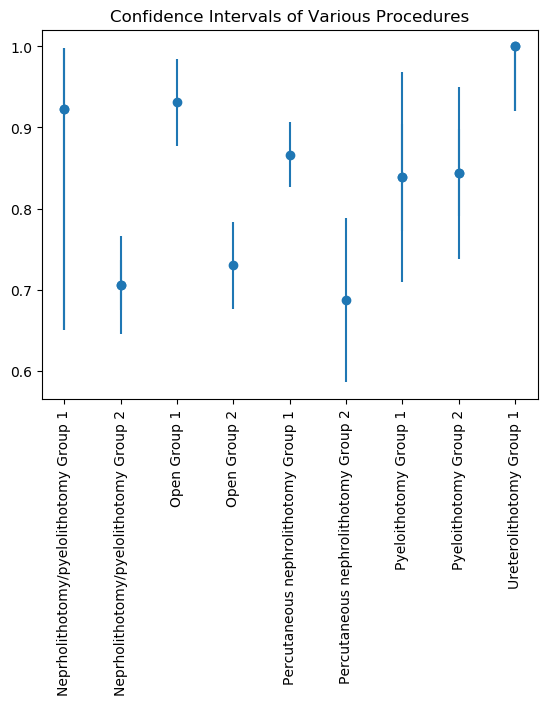

In [141]:
# unpack confidence intervals
lower_error =[]
point_estimate = []
upper_error =[]
x_axis_names = []
for ci in confidence_intervals:
    lower_error.append(ci[2])
    point_estimate.append(ci[3])
    upper_error.append(ci[4])
    x_axis_names.append(ci[0]+' Group '+str(ci[1]))
lower_error = np.asarray(point_estimate)-np.asarray(lower_error)
point_estimate = np.asarray(point_estimate)
upper_error = np.asarray(upper_error) - np.asarray(point_estimate)
    
# example error bar values that vary with x-position
fig, (ax1) = plt.subplots(nrows=1, sharex=True)

asymmetric_error = [lower_error, upper_error]

ax1.errorbar(x_axis_names, point_estimate, yerr=asymmetric_error, fmt='o')
ax1.set_title('Confidence Intervals of Various Procedures')
plt.xticks(rotation=90)
plt.show()



# Conclusion

While the evidence is not statistically that strong, there does appear to be some evidence that in Group 1 patients Ureterolithotomy outperforms Percutaneous Nephrolithotomy, and in Group 2 there is meager evidence that Pyelithtomy outperforms Percutaneous Nephrolithotomy. However given the possibility of the multiple comparisons problem it is hard to say this with great confidence.

# Sources

https://onlinecourses.science.psu.edu/stat500/node/55/
http://sphweb.bumc.bu.edu/otlt/MPH-Modules/QuantCore/PH717_ConfidenceIntervals-OneSample/PH717_ConfidenceIntervals-OneSample5.html
https://matplotlib.org/examples/statistics/errorbar_demo_features.html